# Denoising AutoEncoder

1. CNN+AE
2. CNN+AE+BatchNorm
3. CNN+AE+SSIMLoss

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction
import pandas as pd

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
paperFolder = "/Users/yukihorikawa/Desktop/LAB_LAST/paper/paper/data"

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


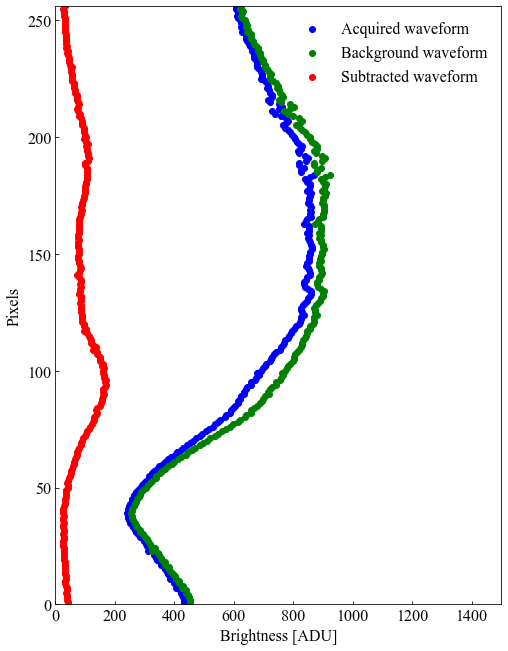

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


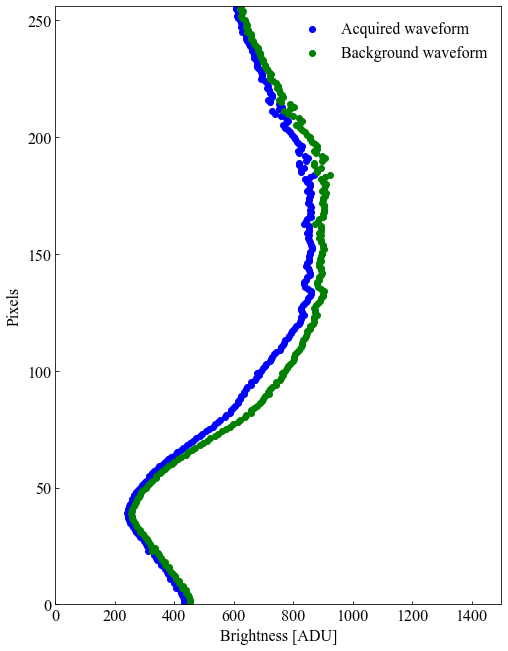

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


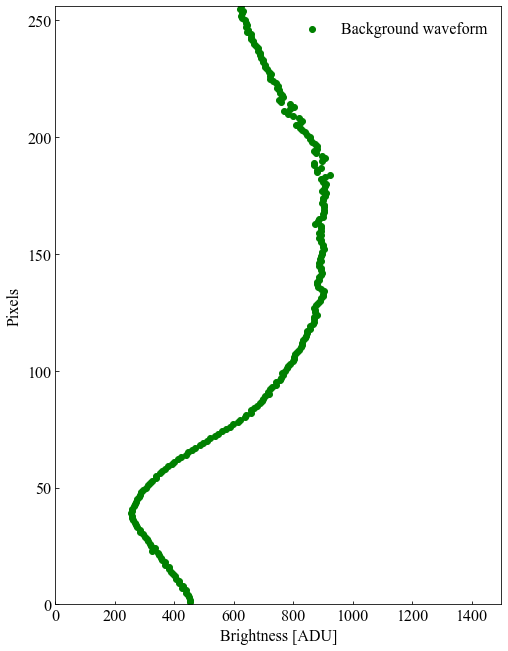

In [147]:
name = "/diff"
pathName = paperFolder+name
path = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224OldSensorData/syuuronsample]/tyokuritu/BRIGHTNESS0/sensor_val.csv"
data_df = pd.read_csv(path, header=None, engine="python")
data_diff = np.array(data_df.iloc[3:, 3].reset_index(drop = True).values,dtype = np.int64)
data_brightness = np.array(data_df.iloc[3:, 1].reset_index(drop = True).values,dtype = np.int64)
data_background = np.array(data_df.iloc[3:, 2].reset_index(drop = True).values,dtype = np.int64)
# plt.clf()

name = "/diff"
pathName = paperFolder+name
plt.figure(figsize=(8,11))

plt.xlim(0,1500)
plt.ylim(0,256)
plt.xlabel('Brightness [ADU]')
plt.ylabel('Pixels')
plt.scatter(data_brightness,range(256,0,-1),label='Acquired waveform', color="blue")
plt.scatter(data_background,range(256,0,-1),label = 'Background waveform', color="green")
plt.scatter(data_diff,range(256,0,-1),label='Subtracted waveform', color = "red")

plt.legend(edgecolor='white')

plt.savefig(pathName+".eps", bbox_inches="tight", pad_inches=0.05) 
plt.savefig(pathName+".pdf", bbox_inches="tight", pad_inches=0.05) 
plt.show()

name = "/Acquired"
pathName = paperFolder+name
plt.figure(figsize=(8,11))

plt.xlim(0,1500)
plt.ylim(0,256)
plt.xlabel('Brightness [ADU]')
plt.ylabel('Pixels')
plt.scatter(data_brightness,range(256,0,-1),label='Acquired waveform', color="blue")
plt.scatter(data_background,range(256,0,-1),label = 'Background waveform', color="green")
# plt.scatter(data_diff,range(256,0,-1),label='Subtracted waveform', color = "red")

plt.legend(edgecolor='white')

plt.savefig(pathName+".eps", bbox_inches="tight", pad_inches=0.05) 
plt.savefig(pathName+".pdf", bbox_inches="tight", pad_inches=0.05) 
plt.show()


name = "/Background"
pathName = paperFolder+name
plt.figure(figsize=(8,11))

plt.xlim(0,1500)
plt.ylim(0,256)
plt.xlabel('Brightness [ADU]')
plt.ylabel('Pixels')
# plt.scatter(data_brightness,range(256,0,-1),label='Acquired waveform', color="blue")
plt.scatter(data_background,range(256,0,-1),label = 'Background waveform', color="green")
# plt.scatter(data_diff,range(256,0,-1),label='Subtracted waveform', color = "red")

plt.legend(edgecolor='white')

plt.savefig(pathName+".eps", bbox_inches="tight", pad_inches=0.05) 
plt.savefig(pathName+".pdf", bbox_inches="tight", pad_inches=0.05) 
plt.show()

## 学習データ作成

old Sensr Data

In [ ]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("sample_data", "sample_test", 1000, 128, 1)


## New Sensor Data

In [ ]:

# Dataset = dataset.dataset(npyFlag=True)
# epochStr = 300
# epochSizeStr = 1024
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)


## OldSensor Data


In [19]:

Dataset = dataset.dataset(npyFlag=True)
epochStr = 500
epochSizeStr = 256
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)

(2560, 256)
(179, 256)
706 0
rate 0.9
data.shape[0]: 2560
rate 2304
TrainData (500, 256, 1, 1, 256)
TestData (256, 256)
ÄnomalyDta (179, 256)


## モデル学習

Denoise AE


In [20]:

losslist=[]
#model
model_CnnAE = mainmodel.Autoencoder_cnn()#model1
model_norm = mainmodel.Autoencoder_batchnorm2()#model2
#loss
criterion_mse = nn.MSELoss()
criterion_ssim = LossFunction.SSIMLoss()

model = model_norm
criterion = criterion_mse

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
input = torch.from_numpy(data.astype(np.float32)).clone()
ori_input = torch.from_numpy(ori_data.astype(np.float32)).clone()
cnt = 0
for (epoch, epoch_ori) in zip(input, ori_input):
    cnt+=1
    for (x, y) in zip(epoch, epoch_ori):
        recon = model(x)
        # print("type:recon_data{}".format(type(recon)))
        loss = criterion(recon, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:{}, Loss:{:.4f}'.format(cnt, float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

make
epoch:1, Loss:0.0384
epoch:2, Loss:0.0155
epoch:3, Loss:0.0159
epoch:4, Loss:0.0081
epoch:5, Loss:0.0117
epoch:6, Loss:0.0095
epoch:7, Loss:0.0072
epoch:8, Loss:0.0321
epoch:9, Loss:0.0071
epoch:10, Loss:0.0229
epoch:11, Loss:0.0053
epoch:12, Loss:0.0058
epoch:13, Loss:0.0033
epoch:14, Loss:0.0055
epoch:15, Loss:0.0040
epoch:16, Loss:0.0058
epoch:17, Loss:0.0023
epoch:18, Loss:0.0025
epoch:19, Loss:0.0038
epoch:20, Loss:0.0022
epoch:21, Loss:0.0030
epoch:22, Loss:0.0017
epoch:23, Loss:0.0028
epoch:24, Loss:0.0034
epoch:25, Loss:0.0033
epoch:26, Loss:0.0031
epoch:27, Loss:0.0021
epoch:28, Loss:0.0030
epoch:29, Loss:0.0024
epoch:30, Loss:0.0038
epoch:31, Loss:0.0032
epoch:32, Loss:0.0032
epoch:33, Loss:0.0019
epoch:34, Loss:0.0218
epoch:35, Loss:0.0130
epoch:36, Loss:0.0039
epoch:37, Loss:0.0038
epoch:38, Loss:0.0022
epoch:39, Loss:0.0019
epoch:40, Loss:0.0030
epoch:41, Loss:0.0028
epoch:42, Loss:0.0028
epoch:43, Loss:0.0027
epoch:44, Loss:0.0017
epoch:45, Loss:0.0035
epoch:46, Loss

## モデルの保存

In [21]:
folder_name = "oldSensor"
model_name = "Denoising_Autoencoder_batchnorm2"+"epoch_"+str(epochStr)+"epockSize_"+str(epochSizeStr)
ModelEdit = mainmodel.Modeledit(folder_name,model_name)
ModelEdit.save_model(model)

# モデルロード

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction
model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensorLoop/Denoising_AE_CNNepoch_400epockSize_512/20211226/Denoising_AE_CNNepoch_400epockSize_512070412.pth"
input_model = mainmodel.Autoencoder_batchnorm()#model2
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_model = input_mode.to(device)
input_model.load_state_dict(torch.load(model_name, map_location=device))
model = input_model

Dataset = dataset.dataset(npyFlag=True)
epochStr = 1
epochSizeStr = 100
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)

(2560, 256)
(179, 256)
706 0
rate 0.9
data.shape[0]: 2560
rate 2304
TrainData (1, 100, 1, 1, 256)
TestData (256, 256)
ÄnomalyDta (179, 256)


## 結果の確認

<class 'torch.Tensor'>


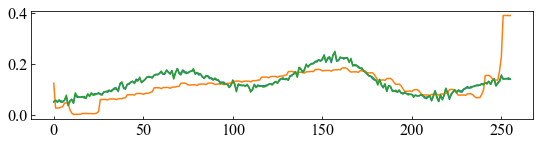

normal:9.21788795106113


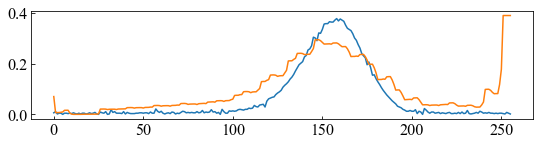

anomarly:12.227760470472276
anomaly
<class 'torch.Tensor'>


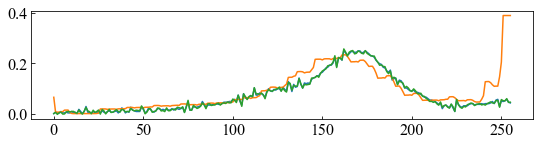

normal:7.0817219469045085


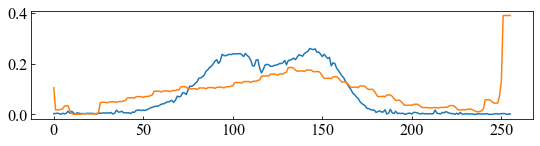

anomarly:13.679494381620316
anomaly


In [22]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 100 == 0:

        
        try:
            data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
            input0 =  torch.from_numpy((data[i]).astype(np.float32)).clone()
            ori_input0 =  torch.from_numpy((ori_data[i]).astype(np.float32)).clone()
            # ori_input0 =  ori_data[i]
            test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
            print(type(data0))
            plt.figure(figsize=(9, 2))
            # data = data0.numpy()
            ori_input0 = ori_input0[i, :, :, :]
            input0 = input0[i, :, :, :]
            recon = model(ori_input0).detach().numpy()
            ori_input0 = ori_input0[0, 0, :]
            input0 = input0[0, 0, :]
            plt.plot(ori_input0)
            plt.plot(recon.flatten())
            plt.plot(input0)
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-ori_input0.numpy()))
            print("normal:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
                
            plt.figure(figsize=(9, 2))
            # data = test0.numpy()
            ano_data = test0[np.newaxis, np.newaxis, :]
            recon = model(ano_data).detach().numpy()
            plt.plot(test0.numpy(),label="testdata")
            plt.plot(recon.flatten(),label="recondata")
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
            print("anomarly:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
        except IndexError:
            print("Finish")
            break

## 異常検知

Error:0
anomalyScore:0.47940322245695344


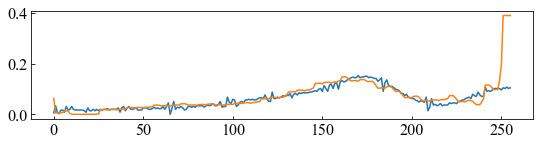

Error:100
anomalyScore:0.47664583231944135


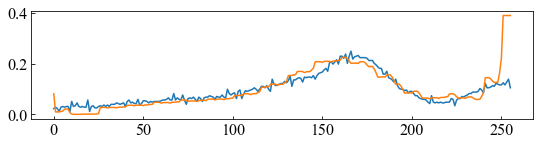

TH:0.8
normalData:179
Correct[%]94.97206703910615%
anomalyData:179
Correct[%]100.0%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


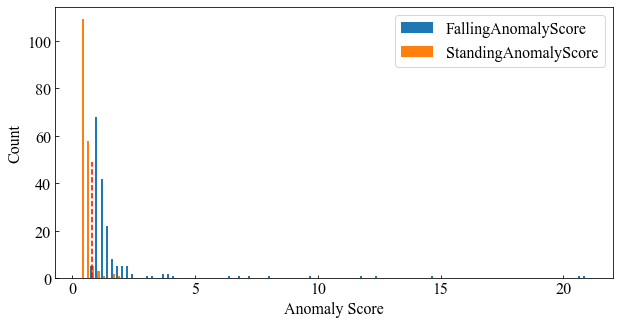

Conbi Data


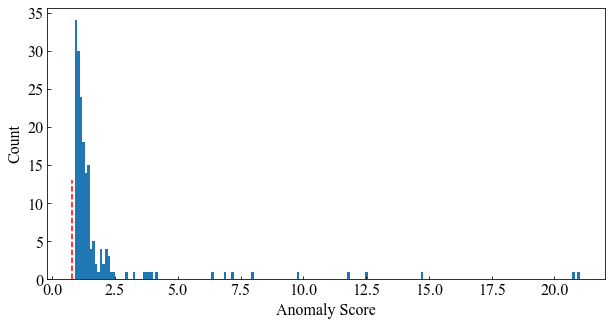

FallingAnomalyScore


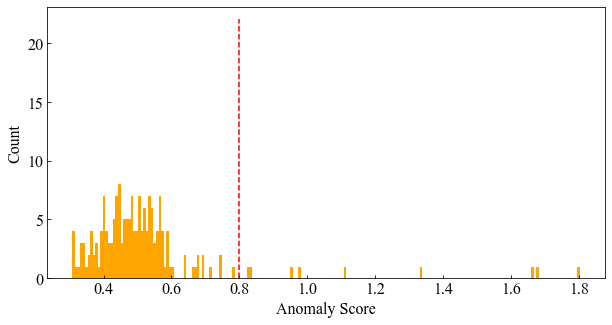

StandingAnomalyScore
standingAnomalyScore
TH:0.44
[0.48, 0.38, 0.33, 0.45, 0.47, 0.44, 0.66, 0.5, 0.41, 0.6, 0.56, 0.31, 0.4, 0.47, 0.5, 0.47, 0.37, 0.37, 0.36, 0.51, 0.44, 0.57, 0.44, 0.45, 0.51, 0.4, 0.53, 0.41, 0.48, 0.37, 0.46, 0.74, 0.33, 0.46, 0.52, 0.44, 0.51, 0.38, 0.67, 0.34, 0.4, 0.52, 0.59, 0.49, 0.43, 0.38, 0.49, 0.53, 0.56, 0.55, 0.57, 0.46, 0.56, 0.4, 0.45, 0.7, 0.53, 0.56, 0.51, 0.37, 0.5, 0.54, 0.52, 0.52, 0.43, 0.47, 0.58, 0.55, 0.49, 0.44, 0.32, 0.78, 0.59, 0.54, 0.51, 0.84, 0.4, 0.43, 0.6, 0.83, 0.56, 0.64, 0.47, 0.42, 0.54, 0.57, 0.54, 0.56, 0.35, 0.53, 0.44, 0.95, 0.45, 1.33, 1.68, 0.45, 0.48, 0.43, 0.48, 0.43, 0.48, 0.55, 0.68, 0.52, 1.11, 0.55, 0.4, 0.59, 0.53, 0.52, 0.56, 0.75, 0.72, 0.98, 0.49, 0.35, 0.56, 0.57, 0.56, 0.58, 0.43, 0.53, 0.4, 0.5, 0.39, 0.31, 1.67, 0.51, 0.58, 0.41, 0.67, 0.34, 0.39, 0.51, 0.49, 0.55, 0.44, 0.5, 0.36, 0.46, 0.54, 0.41, 0.49, 0.46, 0.39, 0.41, 0.45, 0.54, 0.54, 0.43, 0.34, 0.46, 0.44, 0.34, 0.4, 0.52, 0.49, 0.33, 0.31, 0.47, 0.64,

In [23]:
import statistics
import scipy
AnomalyCorrectPoint = 0
StandardCorrectPoint = 0
anomalyScoreList=[]
thr = 0.8
for i in range(anomaly_data.shape[0]):
    try:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        data = data0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-data0.numpy())**2))
        
        # if(anomalyScoreList[i]<=thr):
        if(False):
            pass
        else:
            if i % 100 == 0:
                print('Error:'+str(i))
                print('anomalyScore:'+str(anomalyScoreList[i]))
                plt.figure(figsize=(9, 2))
                plt.plot(data0.numpy())
                plt.plot(recon.flatten())
                plt.show()             
    except IndexError:
        pass
roundList = [round(i,2) for i in anomalyScoreList]
# thr = np.min(anomalyScoreList)
# thr = scipy.stats.mode(anomalyScoreList)
# thr = min(statistics.multimode(roundList))

print("TH:{}".format(thr))
# print(roundList)
for i in range(anomaly_data.shape[0]):
    try:
        if(anomalyScoreList[i]<=thr):
            StandardCorrectPoint += 1
    except IndexError:
        pass
print('normalData:'+str(anomaly_data.shape[0]))
print('Correct[%]'+str(100*StandardCorrectPoint/anomaly_data.shape[0])+'%')
standingAnomalyScore = anomalyScoreList
AnomalyCorrectPoint = 0
StandardCorrectPoint = 0
anomalyScoreList=[]
for i in range(anomaly_data.shape[0]):
    
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        data = test0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-test0.numpy())**2))
        if(anomalyScoreList[i]>thr):
            AnomalyCorrectPoint += 1

print('anomalyData:'+str(anomaly_data.shape[0]))
print('Correct[%]'+str(100*AnomalyCorrectPoint/anomaly_data.shape[0])+'%')
fallingAnomalyScore = anomalyScoreList



plt.figure(figsize=(10, 5))
plt.hist([fallingAnomalyScore,standingAnomalyScore],label=['FallingAnomalyScore','StandingAnomalyScore'],bins=100)
plt.vlines([thr], 0, 49, "red", linestyles='dashed')
plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("scoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
print("Conbi Data")
plt.figure(figsize=(10, 5))
plt.hist(fallingAnomalyScore,label='FallingAnomalyScore',bins=200)
plt.vlines([thr], 0, 13, "red", linestyles='dashed',label='threshold')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("fallingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
print("FallingAnomalyScore")
plt.figure(figsize=(10, 5))
plt.hist(standingAnomalyScore,label='StandingAnomalyScore',bins=200,color='orange')
plt.vlines([thr], 0, 22, "red", linestyles='dashed')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("standingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()
print("StandingAnomalyScore")
print("standingAnomalyScore")
roundList = [round(i,2) for i in standingAnomalyScore]
thr = min(statistics.multimode(roundList))
print("TH:{}".format(thr))
print(roundList)
print("fallingAnomalyScore")
roundList = [round(i,2) for i in fallingAnomalyScore]
thr = min(statistics.multimode(roundList))
print("TH:{}".format(thr))
print(roundList)

In [8]:
# num = 5
thr = 0.8
for i in range(anomaly_data.shape[0]):
    try:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        input0 =  torch.from_numpy((data[i]).astype(np.float32)).clone()
        ori_input0 =  torch.from_numpy((ori_data[i]).astype(np.float32)).clone()
        # ori_input0 =  ori_data[i]
        print(type(data0))
        plt.figure(figsize=(9, 2))
        # data = data0.numpy()
        ori_input0 = ori_input0[i, :, :, :]
        input0 = input0[i, :, :, :]
        recon = model(ori_input0).detach().numpy()
        ori_input0 = ori_input0[0, 0, :]
        input0 = input0[0, 0, :]
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        plt.figure(figsize=(9, 2))
        # data = test0.numpy()
        ano_data = test0[np.newaxis, np.newaxis, :]
        recon = model(ano_data).detach().numpy()
        plt.plot(test0.numpy(),label="testdata")
        plt.plot(recon.flatten(),label="recondata")
        plt.show()
        
        anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
        print("anomarly:"+str(anomalypoint))
        if(anomalypoint>thr):
            print("AnomalyAnomaly")
    except IndexError:
        print("Finish")
        break

AttributeError: 'Tensor' object has no attribute 'astype'

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

# OCSVM

In [17]:
import dataloader
#OCSVM用データセットロード
Dataset = dataset.dataset(npyFlag=True)
epochStr = 1
epochSizeStr = 100
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)
# Dataset = dataset.dataset("Obrid_AE", "data")
# data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)
#モデルの読み込み必要なら
# model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth"
# input_model = mainmodel.Autoencoder_cnn()
# input_model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_model = mainmodel.Autoencoder_cnn().to(device)
# input_model.load_state_dict(torch.load(model_name, map_location=device))

input_model = model
#OCSVM用再構成後データセットロード
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

(2560, 256)
(179, 256)
706 0
rate 0.9
data.shape[0]: 2560
rate 2304
TrainData (1, 100, 1, 1, 256)
TestData (256, 256)
ÄnomalyDta (179, 256)


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [1, 1, 7], but got 6-dimensional input of size [1, 1, 100, 1, 1, 256] instead

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction
import dataloader
model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/Denoising_Autoencoder_batchnorm2epoch_500epockSize_256/20211228/Denoising_Autoencoder_batchnorm2epoch_500epockSize_256061752.pth"
input_model = mainmodel.Autoencoder_batchnorm2()#model2
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# input_model = input_mode.to(device)
input_model.load_state_dict(torch.load(model_name, map_location=device))
model = input_model

Dataset = dataset.dataset(npyFlag=True)
epochStr = 100
epochSizeStr = 256
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)
data = dataloader.ocsvm_DAE_dataset(data)
#OCSVM用再構成後データセットロード
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

(2560, 256)
(179, 256)
706 0
rate 0.9
data.shape[0]: 2560
rate 2304
TrainData (100, 256, 1, 1, 256)
TestData (256, 256)
ÄnomalyDta (179, 256)
--------1/25600--------
--------2/25600--------
--------4/25600--------
--------5/25600--------
--------8/25600--------
--------10/25600--------
--------16/25600--------
--------20/25600--------
--------25/25600--------
--------32/25600--------
--------40/25600--------
--------50/25600--------
--------64/25600--------
--------80/25600--------
--------100/25600--------
--------125/25600--------
--------128/25600--------
--------160/25600--------
--------200/25600--------
--------250/25600--------
--------256/25600--------
--------320/25600--------
--------400/25600--------
--------500/25600--------
--------512/25600--------
--------640/25600--------
--------800/25600--------
--------1000/25600--------
--------1024/25600--------
--------1280/25600--------
--------1600/25600--------
--------2000/25600--------
--------2048/25600--------
--------2560/

/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/dataloader.py:35: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  input_list = np.array(input_list)
/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/dataloader.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_list = np.array(input_list)


recon_list:(25600, 256)
encoded_list:(25600, 3)
input_list:(25600,)
--------1/256--------
--------2/256--------
--------4/256--------
--------5/256--------
--------8/256--------
--------10/256--------
--------16/256--------
--------20/256--------
--------32/256--------
--------40/256--------
--------64/256--------
--------80/256--------
--------128/256--------
--------160/256--------
recon_list:(256, 256)
encoded_list:(256, 3)
input_list:(256,)
--------1/179--------
--------2/179--------
recon_list:(179, 256)
encoded_list:(179, 3)
input_list:(179,)


## 可視化

y_pred_train:25600 
y_pred_anomaly:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 
y_pred_outliers:[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1] 


/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34307/2985198829.py:62: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')
/var/folders/gl/kcbdb7pj0yz8846ytcdrjm140000gn/T/ipykernel_34307/2985198829.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


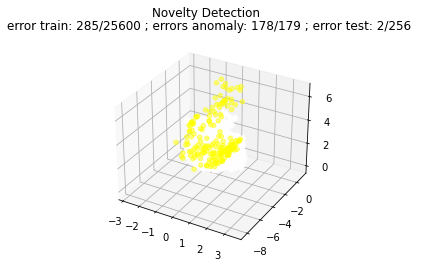

In [4]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list[0:256]

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.5)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()